<a href="https://colab.research.google.com/github/pdbn/Shilling-Attacks-Detection---Beta-VAE/blob/main/FinalMLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

- Load packages and libraries
- Load MovieLens data from Kaggle and preview the data

In [26]:
# Load packages
import kagglehub
import numpy as np
import pandas as pd
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)

In [27]:


# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)
ratings_path = os.path.join(path, 'rating.csv')
movies_path = os.path.join(path, 'movie.csv')

# Load the datasets
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Preview data
print(ratings.head())
print(movies.head())


Path to dataset files: /kaggle/input/movielens-20m-dataset
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  



# Data Preprocessing
- **Filter for ratings after 18-02-2003 for consistency**, since the ratings change from whole star (1-5) to half-star ratings (0.5-5) after that date
- **Randomly sample 1%** so that the dataset is more manageable
- Examine how the dataset looks like
- **Filter for users with at least 5 ratings and movies rated at least 5 times**
 (due to random sampling, users/movies can have 0 ratings in the sample)

In [28]:
# Convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], utc=True, errors='coerce')
ratings['date'] = ratings['datetime'].dt.date

# Filter for ratings on or after 2003-02-18 (half-star rating)
filtered_ratings = ratings[ratings['date'] >= datetime(2003, 2, 18).date()]

# Sample 1%
sample_size = 0.01
filtered_ratings = filtered_ratings.sample(frac=sample_size, random_state=42).reset_index(drop=True)

# Examine the dataset
filtered_ratings = filtered_ratings.merge(movies, on='movieId', how='left')
filtered_ratings.head()

print(filtered_ratings.columns)

def check_min_ratings_df(df):
    """
    Check the minimum number of ratings per user and per movie
    in the long-format ratings DataFrame.
    """
    user_counts = df['userId'].value_counts()
    movie_counts = df['movieId'].value_counts()

    print(f"Users: {df['userId'].nunique()}, Movies: {df['movieId'].nunique()}")
    print(f"Min ratings per user: {user_counts.min()}")
    print(f"Min ratings per movie: {movie_counts.min()}")

check_min_ratings_df(filtered_ratings)

Index(['userId', 'movieId', 'rating', 'timestamp', 'datetime', 'date', 'title',
       'genres'],
      dtype='object')
Users: 40786, Movies: 9621
Min ratings per user: 1
Min ratings per movie: 1


In [29]:
# Sample where users rate ≥ 5 movies and each movie is rated ≥ 5 times
def sample_ratings(ratings_df, min_user_ratings, min_movie_ratings):
    while True:
        # Filter movies with at least min_movie_ratings
        movie_counts = ratings_df['movieId'].value_counts()
        eligible_movies = movie_counts[movie_counts >= min_movie_ratings].index

        # Filter users who rated eligible movies
        filtered = ratings_df[ratings_df['movieId'].isin(eligible_movies)]
        user_counts = filtered['userId'].value_counts()
        eligible_users = user_counts[user_counts >= min_user_ratings].index

        # Final filtered data
        new_sample = filtered[filtered['userId'].isin(eligible_users)]

        if len(new_sample) == len(ratings_df):
            break
        else:
            ratings_df = new_sample.copy()

    return ratings_df.reset_index(drop=True)

ratings_sample = sample_ratings(filtered_ratings, min_user_ratings=5, min_movie_ratings=5)

In [30]:
# Create the rating matrix (user x movie)
ratings_matrix_df = ratings_sample.pivot(index='userId', columns='movieId', values='rating')
ratings_matrix = ratings_matrix_df.to_numpy()
movie_ids = ratings_matrix_df.columns.astype(str)

print("Number of users:", ratings_matrix.shape[0])
print("Number of movies:", ratings_matrix.shape[1])

Number of users: 5849
Number of movies: 2720


# Data Overview
- Sparsity check
- User & Movie Behavior overview, rating distribution


In [31]:
def check_sparsity(matrix):
    """Print number and percentage of missing values in the matrix."""
    total_elements = matrix.size
    missing_values = np.isnan(matrix).sum()
    percent_missing = (missing_values / total_elements) * 100

    print(f"Total values: {total_elements:,}")
    print(f"Missing (NaN) values: {missing_values:,}")
    print(f"Sparsity (NaNs %): {percent_missing:.2f}%")

def check_min_ratings(matrix):
    ratings_per_user = np.sum(~np.isnan(matrix), axis=1)
    ratings_per_movie = np.sum(~np.isnan(matrix), axis=0)
    print("Minimum number of ratings per user:", np.min(ratings_per_user))
    print("Minimum number of ratings per movie:", np.min(ratings_per_movie))

check_sparsity(ratings_matrix)
check_min_ratings(ratings_matrix)

Total values: 15,909,280
Missing (NaN) values: 15,866,327
Sparsity (NaNs %): 99.73%
Minimum number of ratings per user: 5
Minimum number of ratings per movie: 5


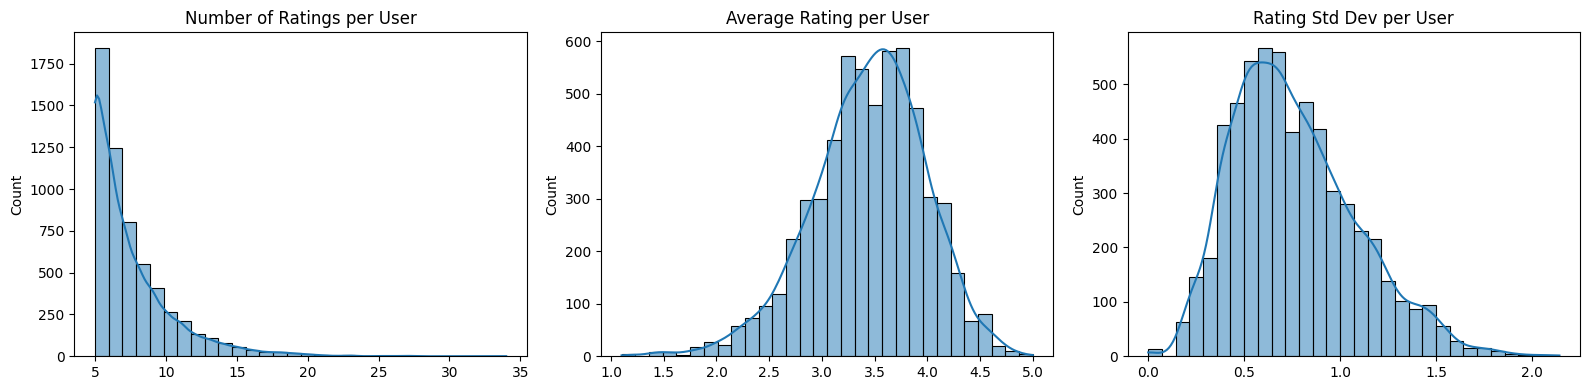

In [32]:
# User's behavior overview
def analyze_user_behavior(matrix):
    ratings_per_user = np.sum(~np.isnan(matrix), axis=1)
    avg_rating_per_user = np.nanmean(matrix, axis=1)
    std_rating_per_user = np.nanstd(matrix, axis=1)

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    sns.histplot(ratings_per_user, bins=30, kde=True)
    plt.title("Number of Ratings per User")

    plt.subplot(1, 3, 2)
    sns.histplot(avg_rating_per_user, bins=30, kde=True)
    plt.title("Average Rating per User")

    plt.subplot(1, 3, 3)
    sns.histplot(std_rating_per_user, bins=30, kde=True)
    plt.title("Rating Std Dev per User")

    plt.tight_layout()
    plt.show()

analyze_user_behavior(ratings_matrix)

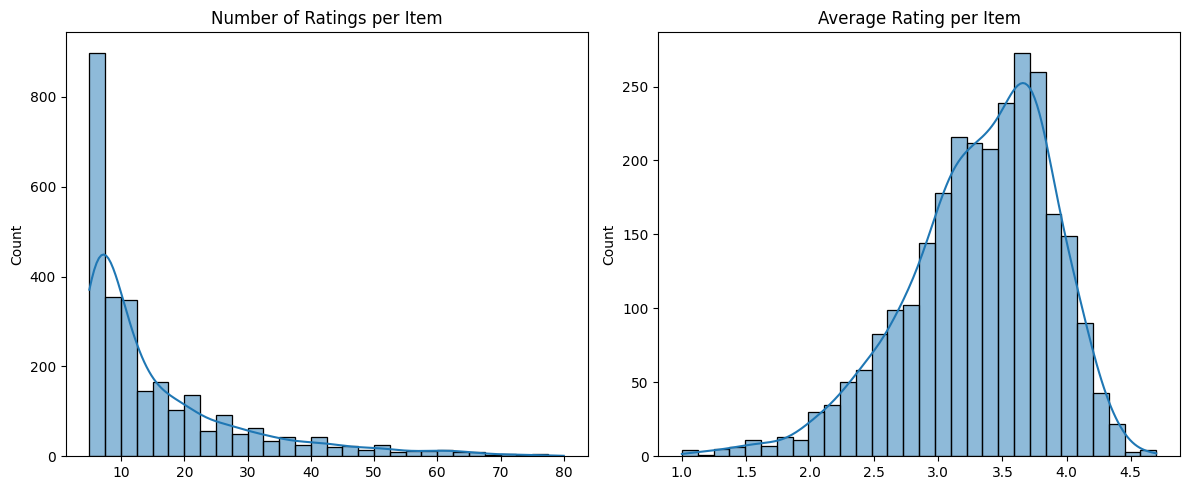

In [33]:
# Movie's behavior overview
def analyze_item_behavior(matrix):
    ratings_per_item = np.sum(~np.isnan(matrix), axis=0)
    avg_rating_per_item = np.nanmean(matrix, axis=0)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(ratings_per_item, bins=30, kde=True)
    plt.title("Number of Ratings per Item")

    plt.subplot(1, 2, 2)
    sns.histplot(avg_rating_per_item, bins=30, kde=True)
    plt.title("Average Rating per Item")

    plt.tight_layout()
    plt.show()

analyze_item_behavior(ratings_matrix)

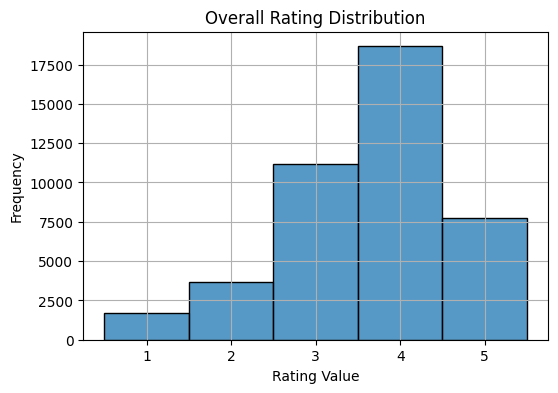

In [34]:
# Rating distribution
def analyze_rating_distribution(matrix):
    flattened_ratings = matrix[~np.isnan(matrix)]

    plt.figure(figsize=(6, 4))
    sns.histplot(flattened_ratings, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], kde=False)
    plt.title("Overall Rating Distribution")
    plt.xlabel("Rating Value")
    plt.ylabel("Frequency")
    plt.xticks([1, 2, 3, 4, 5])
    plt.grid(True)
    plt.show()

analyze_rating_distribution(ratings_matrix)

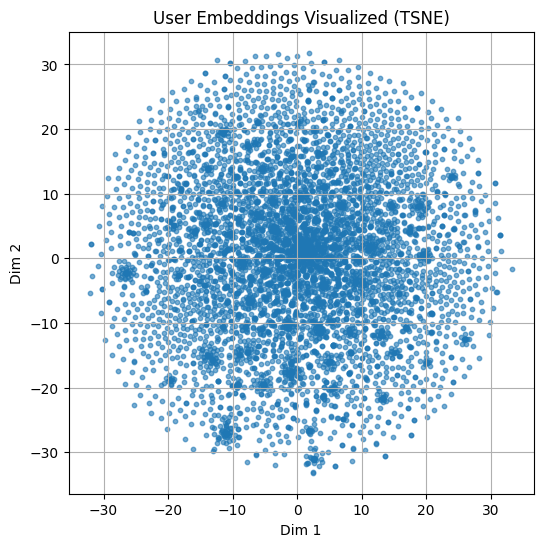

In [35]:
# Testing: visualize clusters of normal users' rating behavior
# 2 options: PCA or tsne, default I set to PCA

def visualize_user_latents(matrix, method='pca'):
    # Fill NaNs with zeros (or mean if preferred)
    filled_matrix = np.nan_to_num(matrix, nan=0.0)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=26)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    reduced = reducer.fit_transform(filled_matrix)

    plt.figure(figsize=(6, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=10, alpha=0.6)
    plt.title(f"User Embeddings Visualized ({method.upper()})")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

visualize_user_latents(ratings_matrix, method='tsne')

# Model Training
- Standardize ratings
- Split into train and test users (test users will later contain normal users and injected attackers; while train users only contain normal users)
- $\beta$-VAE with masking + KL Annealing since encounter KL vanishing + Hyperparameter tuning using Grid Search

In [36]:
# Standardize ratings for users
def standardize_per_user(matrix):
    means = np.nanmean(matrix, axis=1, keepdims=True)
    stds = np.nanstd(matrix, axis=1, keepdims=True)
    stds[stds == 0] = 1  # Prevent division by zero
    standardized = (matrix - means) / stds
    return standardized, means, stds

ratings_std, user_means, user_stds = standardize_per_user(ratings_matrix)

# Split into train and test sets
np.random.seed(26)
n_users = ratings_std.shape[0]
indices = np.random.permutation(n_users)
train_size = int(0.8 * n_users)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

ratings_train = ratings_std[train_indices]
ratings_test = ratings_std[test_indices]  # will later contain injected attackers

Main VAE model

In [37]:
class RatingDataset(Dataset):
    def __init__(self, rating_matrix):
        self.X = torch.tensor(np.nan_to_num(rating_matrix, nan=0.0), dtype=torch.float32)
        self.mask = torch.tensor(~np.isnan(rating_matrix), dtype=torch.bool)

    def __getitem__(self, idx):
        return self.X[idx], self.mask[idx]

    def __len__(self):
        return self.X.shape[0]

# VAE Model
class VAE(nn.Module):
    def __init__(self, n_items, latent_dim=20, hidden_dim=100):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_items, hidden_dim),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_items),
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        recon = self.decoder(z)
        return recon, mu, logvar

# Loss function
def loss_function(recon_x, x, mask, mu, logvar, beta=1.0):
    masked_diff = ((recon_x - x) ** 2) * mask
    recon_loss = masked_diff.sum() / mask.sum()
    kld = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    total_loss = recon_loss + beta * kld
    return total_loss, recon_loss, kld

# KL Annealing
def get_beta(epoch, max_beta=1.0, anneal_epochs=10, schedule='linear'):
    if schedule == 'linear':
        return min(max_beta, epoch / anneal_epochs * max_beta)
    elif schedule == 'sigmoid':
        from math import exp
        return max_beta / (1 + exp(-0.3 * (epoch - anneal_epochs)))
    else:  # constant
        return max_beta

# Train
def train_vae(model, loader, n_epochs=30, lr=1e-3, max_beta=1.0, schedule='linear', device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = []

    for epoch in range(n_epochs):
        beta = get_beta(epoch, max_beta=max_beta, schedule=schedule)
        model.train()
        total_loss, total_recon, total_kld = 0.0, 0.0, 0.0
        num_batches = 0

        for batch, mask in loader:
            batch, mask = batch.to(device), mask.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch)
            loss, recon_loss, kld = loss_function(recon, batch, mask, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        avg_recon = total_recon / num_batches
        avg_kld = total_kld / num_batches
        history.append((avg_loss, avg_recon, avg_kld))

        print(f"Epoch {epoch+1:2d}: Total={avg_loss:.4f}, Recon={avg_recon:.4f}, KLD={avg_kld:.4f}, β={beta:.4f}")

    return model, history


Hyperparameter tuning using grid search:

In [38]:
def run_hyperparameter_search():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    param_grid = {
        'latent_dim': [4, 16, 32],
        'hidden_dim': [32, 64],
        'lr': [1e-3],
        'batch_size': [64],
        'beta': [0.1, 0.25, 0.5],
        'beta_schedule': ['linear', 'sigmoid']
    }

    grid = list(ParameterGrid(param_grid))
    results = []

    best_loss = float('inf')
    best_run = None

    for run_id, params in enumerate(grid):
        print(f" Run {run_id + 1}/{len(grid)} — Config: {params}")
        torch.cuda.empty_cache()

        dataset = RatingDataset(ratings_train)
        loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)

        model = VAE(n_items=ratings_train.shape[1],
                    latent_dim=params['latent_dim'],
                    hidden_dim=params['hidden_dim'])

        trained_model, history = train_vae(
            model,
            loader,
            n_epochs=30,
            lr=params['lr'],
            max_beta=params['beta'],
            schedule=params['beta_schedule'],
            device=device
        )

        final_total_loss = history[-1][0]
        run_result = {
            **params,
            'final_total_loss': final_total_loss,
            'loss_history': history
        }
        results.append(run_result)

        if final_total_loss < best_loss:
            best_loss = final_total_loss
            best_run = run_result

    results_df = pd.DataFrame(results).sort_values(by='final_total_loss')
    return results_df, best_run


 Run 1/36 — Config: {'batch_size': 64, 'beta': 0.1, 'beta_schedule': 'linear', 'hidden_dim': 32, 'latent_dim': 4, 'lr': 0.001}
Epoch  1: Total=1.0346, Recon=1.0346, KLD=0.0348, β=0.0000
Epoch  2: Total=0.9392, Recon=0.9376, KLD=0.1578, β=0.0100
Epoch  3: Total=0.8648, Recon=0.8586, KLD=0.3074, β=0.0200
Epoch  4: Total=0.7907, Recon=0.7728, KLD=0.5970, β=0.0300
Epoch  5: Total=0.7419, Recon=0.7015, KLD=1.0109, β=0.0400
Epoch  6: Total=0.7108, Recon=0.6486, KLD=1.2430, β=0.0500
Epoch  7: Total=0.6901, Recon=0.6112, KLD=1.3148, β=0.0600
Epoch  8: Total=0.6821, Recon=0.5880, KLD=1.3438, β=0.0700
Epoch  9: Total=0.6772, Recon=0.5747, KLD=1.2812, β=0.0800
Epoch 10: Total=0.6714, Recon=0.5607, KLD=1.2300, β=0.0900
Epoch 11: Total=0.6711, Recon=0.5542, KLD=1.1687, β=0.1000
Epoch 12: Total=0.6621, Recon=0.5445, KLD=1.1757, β=0.1000
Epoch 13: Total=0.6563, Recon=0.5352, KLD=1.2112, β=0.1000
Epoch 14: Total=0.6482, Recon=0.5198, KLD=1.2839, β=0.1000
Epoch 15: Total=0.6415, Recon=0.5082, KLD=1.333

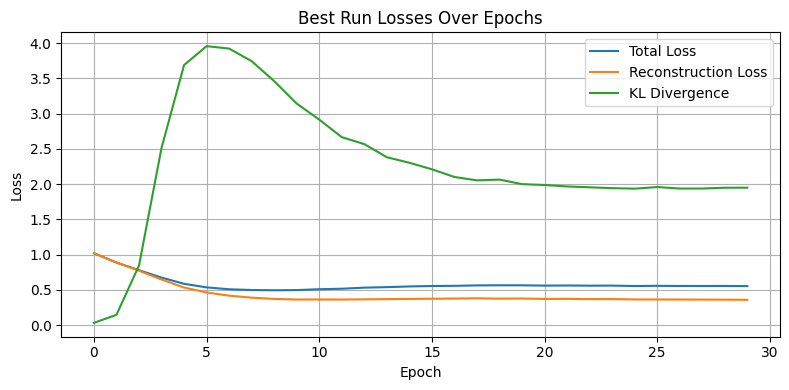

In [39]:
results_df, best_run = run_hyperparameter_search()

# Plot Best Run
plt.figure(figsize=(8, 4))
losses = np.array(best_run['loss_history'])
plt.plot(losses[:, 0], label='Total Loss')
plt.plot(losses[:, 1], label='Reconstruction Loss')
plt.plot(losses[:, 2], label='KL Divergence')
plt.title("Best Run Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Get best hyperparameters from search and run on full training set using best config

In [40]:
best_params = results_df.iloc[0].to_dict()
print("\nBest hyperparameters:")
for k, v in best_params.items():
    if k != 'loss_history':
        print(f"{k}: {v}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = RatingDataset(ratings_train)
loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True)

best_model = VAE(
    n_items=ratings_train.shape[1],
    latent_dim=best_params['latent_dim'],
    hidden_dim=best_params['hidden_dim']
)

trained_model, best_history = train_vae(
    best_model,
    loader,
    n_epochs=100,
    lr=best_params['lr'],
    max_beta=best_params['beta'],
    schedule=best_params['beta_schedule'],
    device=device
)

# Save trained model
torch.save(trained_model.state_dict(), 'vae_best_model.pt')
with open('vae_best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

print("✅ Best VAE model saved to 'vae_best_model.pt'")


Best hyperparameters:
batch_size: 64
beta: 0.1
beta_schedule: sigmoid
hidden_dim: 64
latent_dim: 4
lr: 0.001
final_total_loss: 0.554820879488378
Epoch  1: Total=1.0134, Recon=1.0132, KLD=0.0336, β=0.0047
Epoch  2: Total=0.8838, Recon=0.8825, KLD=0.2016, β=0.0063
Epoch  3: Total=0.7719, Recon=0.7639, KLD=0.9578, β=0.0083
Epoch  4: Total=0.6582, Recon=0.6277, KLD=2.7924, β=0.0109
Epoch  5: Total=0.5810, Recon=0.5287, KLD=3.6853, β=0.0142
Epoch  6: Total=0.5387, Recon=0.4655, KLD=4.0167, β=0.0182
Epoch  7: Total=0.5116, Recon=0.4198, KLD=3.9648, β=0.0231
Epoch  8: Total=0.4989, Recon=0.3903, KLD=3.7562, β=0.0289
Epoch  9: Total=0.4975, Recon=0.3737, KLD=3.4948, β=0.0354
Epoch 10: Total=0.5057, Recon=0.3690, KLD=3.2105, β=0.0426
Epoch 11: Total=0.5168, Recon=0.3669, KLD=2.9993, β=0.0500
Epoch 12: Total=0.5257, Recon=0.3683, KLD=2.7415, β=0.0574
Epoch 13: Total=0.5333, Recon=0.3657, KLD=2.5965, β=0.0646
Epoch 14: Total=0.5449, Recon=0.3739, KLD=2.4048, β=0.0711
Epoch 15: Total=0.5498, Reco

# Simulate shilling attacks
- Inject attack profiles (3 types): random, average, bandwagon
- Inject into test set

In [41]:
# Generate attack profiles (3 possible attack types)
def generate_attack_profiles(n_attackers, ratings_matrix, attack_type='random', target_item=0, rating_scale=(1, 5), filler_size=10):
    n_items = ratings_matrix.shape[1]
    min_rating, max_rating = rating_scale
    attacker_profiles = []

    # Compute item popularity and average ratings from clean data
    item_means = np.nanmean(ratings_matrix, axis=0)
    item_popularity = np.sum(~np.isnan(ratings_matrix), axis=0)

    for _ in range(n_attackers):
        profile = np.full(n_items, np.nan)

        if attack_type == 'random':
            filler_items = np.random.choice(np.delete(np.arange(n_items), target_item), size=filler_size, replace=False)
            profile[filler_items] = np.random.uniform(min_rating, max_rating, size=filler_size)

        elif attack_type == 'average':
            filler_items = np.random.choice(np.delete(np.arange(n_items), target_item), size=filler_size, replace=False)
            profile[filler_items] = item_means[filler_items]

        elif attack_type == 'bandwagon':
            # Pick top popular items
            popular_items = np.argsort(-item_popularity)
            filler_items = popular_items[:filler_size]
            profile[filler_items] = max_rating

        # Promote the target item
        profile[target_item] = max_rating
        attacker_profiles.append(profile)

    return np.array(attacker_profiles)

# Inject attack profiles into our test set
def inject_attack_profiles(test_set, attacker_profiles):
    return np.vstack([test_set, attacker_profiles])


In [42]:
# Generate 5% of test users to be attack profiles with 10 target items (arbitrary number)
n_attackers = int(0.05 * ratings_test.shape[0])  # 5% of test users
target_item = 10

attacker_profiles = generate_attack_profiles(
    n_attackers=n_attackers,
    ratings_matrix=ratings_train, #for attacks like average, need to mimic normal users, so using ratings_test would leak test info
    attack_type='average',       # or 'random', 'average'
    target_item=target_item,
    rating_scale=(0.5, 5),
    filler_size=20
)

test_with_attacks = np.vstack([ratings_test, attacker_profiles])

# Add labels since attacks profiles are simulated by us
y_true = np.array([0] * len(ratings_test) + [1] * len(attacker_profiles))

print(f"Injected {n_attackers} attackers into test set.")
print(f"Test set size: {test_with_attacks.shape[0]}, Normal: {len(ratings_test)}, Attacker: {n_attackers}")


Injected 58 attackers into test set.
Test set size: 1228, Normal: 1170, Attacker: 58


/tmp/ipython-input-41-3112389598.py:8: RuntimeWarning: Mean of empty slice
  item_means = np.nanmean(ratings_matrix, axis=0)


A well-trained VAE learns to reconstruct normal user profiles so for attacker, the reconstruction error will be high with different KL divergence.

Pass each user profile through VAE and calculate reconstruction error, KL divergence and combined score to detect anomalies

In [43]:
# Define scores to later detect anomalies
def score_anomalies(model, test_matrix, device='cpu', alpha=1.0, beta=1.0):
    model.eval()
    model.to(device)

    X = torch.tensor(np.nan_to_num(test_matrix, nan=0.0), dtype=torch.float32).to(device)
    mask = torch.tensor(~np.isnan(test_matrix), dtype=torch.bool).to(device)

    recon_x, mu, logvar = model(X)

    # Reconstruction Error
    masked_diff = ((recon_x - X) ** 2) * mask
    recon_error = masked_diff.sum(dim=1) / mask.sum(dim=1)

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    # Combined Anomaly Score
    combined_score = alpha * recon_error + beta * kl_div

    return recon_error.detach().cpu().numpy(), kl_div.detach().cpu().numpy(), combined_score.detach().cpu().numpy()

In [44]:
# Load model
vae = VAE(
    n_items=ratings_train.shape[1],
    latent_dim=best_params['latent_dim'],
    hidden_dim=best_params['hidden_dim']
)
vae.load_state_dict(torch.load('vae_best_model.pt'))
vae.eval()

# Score all users (normal + attacker)
recon_scores, kl_scores, combined_scores = score_anomalies(
    model=vae,
    test_matrix=test_with_attacks,
    device=device,
    alpha=1.0,
    beta=1.0
)

# Store in a DataFrame for easy inspection
import pandas as pd

score_df = pd.DataFrame({
    'Recon': recon_scores,
    'KL': kl_scores,
    'Combined': combined_scores,
    'Label': y_true
})

score_df.head()


,Recon,KL,Combined,Label
0,1.002078,1.554136,2.556213,0
1,0.583042,2.770241,3.353283,0
2,0.879555,1.068351,1.947906,0
3,0.691598,0.865006,1.556604,0
4,0.331758,0.839090,1.170848,0


Thresholding and evaluation using ROC, F1, Confusion Matrix
- ROC: The ROC curve plots the True Positive Rate (also called Sensitivity or Recall) against the False Positive Rate (FPR)
- F1: Precision & Recall

In [45]:
def evaluate_detection(score_df, score_column='Combined', method='quantile', percentile=95):
    # 1. Determine threshold from clean users only
    clean_scores = score_df[score_df['Label'] == 0][score_column]

    if method == 'quantile':
        threshold = np.percentile(clean_scores, percentile)
    elif method == 'std':
        threshold = clean_scores.mean() + 2 * clean_scores.std()
    else:
        raise ValueError("method must be 'quantile' or 'std'")

    # 2. Predict anomalies
    preds = score_df[score_column] > threshold
    y_true = score_df['Label']

    # 3. Metrics
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    roc_auc = roc_auc_score(y_true, score_df[score_column])
    pr_auc = average_precision_score(y_true, score_df[score_column])
    cm = confusion_matrix(y_true, preds)

    print(f" Threshold ({score_column}): {threshold:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}")
    print(f" F1 Score:  {f1:.4f}")
    print(f" ROC AUC:   {roc_auc:.4f}")
    print(f" PR  AUC:   {pr_auc:.4f}")
    print(" Confusion Matrix:")
    print(cm)

    return {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

 Threshold (Combined): 4.0323
 Precision: 0.4870
 Recall:    0.9655
 F1 Score:  0.6474
 ROC AUC:   0.9925
 PR  AUC:   0.8870
 Confusion Matrix:
[[1111   59]
 [   2   56]]


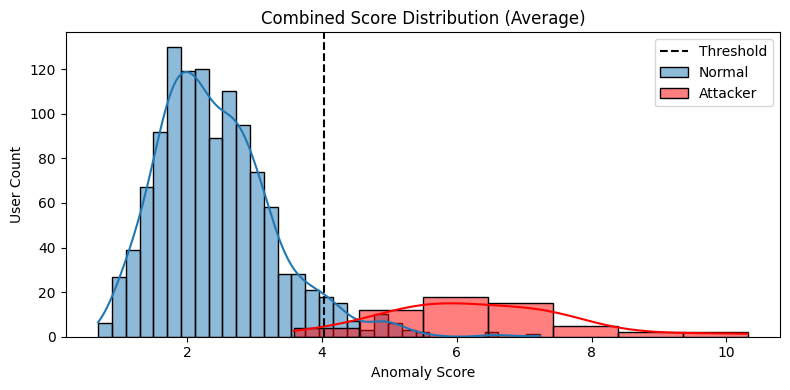

In [46]:
# Evaluation and plot score distributions
results = evaluate_detection(score_df, score_column='Combined', method='quantile', percentile=95)

plt.figure(figsize=(8, 4))
sns.histplot(score_df[score_df['Label'] == 0]['Combined'], label="Normal", kde=True)
sns.histplot(score_df[score_df['Label'] == 1]['Combined'], label="Attacker", kde=True, color='r')
plt.axvline(results['threshold'], color='k', linestyle='--', label='Threshold')
plt.title("Combined Score Distribution (Average)")
plt.xlabel("Anomaly Score")
plt.ylabel("User Count")
plt.legend()
plt.tight_layout()
plt.show()


# Analytical Interpretation
- Latent space visualization:
> Normal users should form clusters while attackers will stand out
- Reconstruction Error Histogram: attackers' profile won't reconstruct well (heavier right tail in histogram)


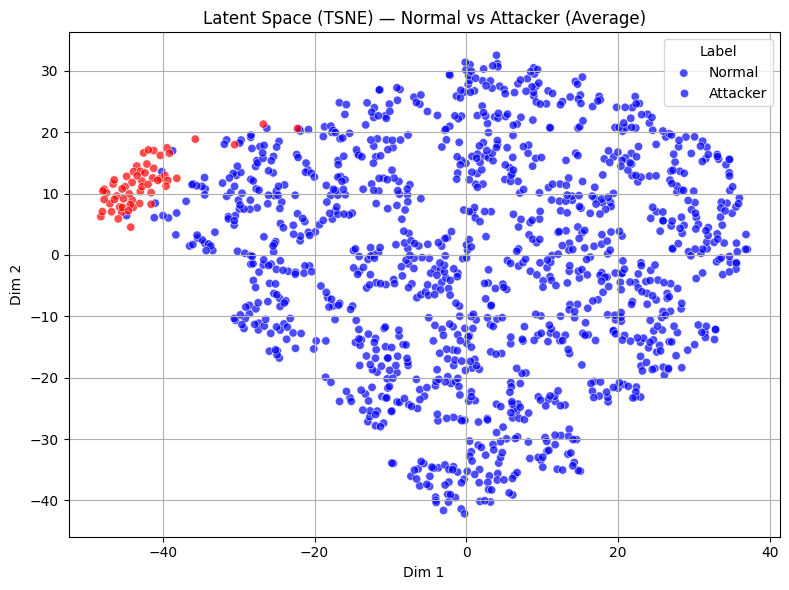

In [47]:
# Latent space visualization
def visualize_latent_space(model, test_matrix, labels, method='tsne', device='cpu'):
    model.eval()
    model.to(device)

    X = torch.tensor(np.nan_to_num(test_matrix, nan=0.0), dtype=torch.float32).to(device)
    with torch.no_grad():
        h = model.encoder(X)
        mu = model.mu(h)  # Use mean of latent distribution

    latent = mu.cpu().numpy()

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    reduced = reducer.fit_transform(latent)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette=['blue', 'red'], alpha=0.7)
    plt.title(f"Latent Space ({method.upper()}) — Normal vs Attacker (Average)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Label", labels=["Normal", "Attacker"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# TSNE or PCA
visualize_latent_space(model=vae, test_matrix=test_with_attacks, labels=y_true, method='tsne', device=device)


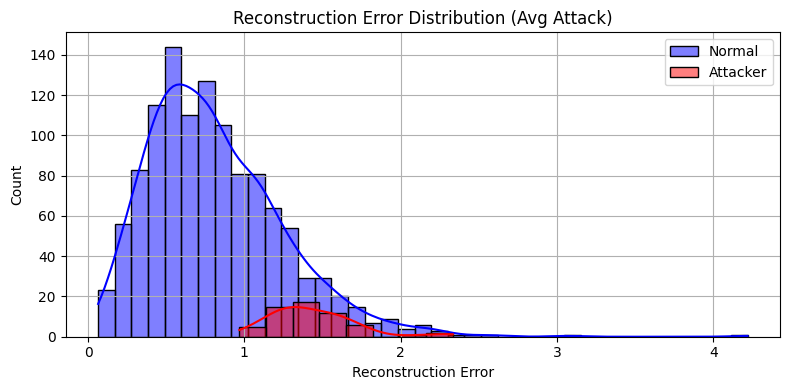

In [48]:
# Histogram Comparison
def plot_recon_error_hist(score_df):
    plt.figure(figsize=(8, 4))
    sns.histplot(score_df[score_df['Label'] == 0]['Recon'], label='Normal', color='blue', kde=True)
    sns.histplot(score_df[score_df['Label'] == 1]['Recon'], label='Attacker', color='red', kde=True)
    plt.title("Reconstruction Error Distribution (Avg Attack)")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_recon_error_hist(score_df)